In [ ]:
!pip install -U pymoo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 KB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210096 sha256=46ed6cf213d7811fcd248b472932326cfba1bbe95deb482c815d70046a725b90
  Stored in directory: /root/.cache/pip/wheels/2d/08/6b/126ea9009f7482fd53a78d0db2ece5aca70af8f4a30445386b
Successfully built grapheme


In [ ]:
!python -c "from pymoo.util.function_loader import is_compiled;print('Compiled Extensions: ', is_compiled())"

Compiled Extensions:  True


### Génération des données 

In [ ]:
import random
import numpy as np
import math 

def generate_random_fog_values(n):
    cpu = []
    cost = []
    for i in range(n):
        execution = random.randint(40000, 150000)
        price = execution * 0.00001 * np.random.normal(5,0.6,1)
        cpu.append(execution)
        cost.append(price)
    return np.array(cpu), np.array(cost)

def generate_random_task_values(n):
    values = []
    for i in range(n):
        execution = random.randint(2000000, 30000000)
        values.append(execution)
    return np.array(values)

# cpu,cost = generate_random_fog_values(5)
# task = generate_random_task_values(20)

# print(task)
# print(cpu)
# print(cost)

task=np.array([3324661,6725193,13723233,5779370,14563959,10202920,18713183,16684225,15556916,9946119,15537110,22322498,14681901,22989230,23444017,13560735,8833867,6920224,13022243,12300466])
cpu=np.array([95546,100505,44292,117400,110803])
cost=np.array([3.46478974,5.69474934,1.9086627 ,6.94341464,5.03096405])

### Implémentation de nsga 2


In [ ]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class TaskServerProblem(ElementwiseProblem):
    def __init__(self, n_tasks, n_servers):
        super().__init__(n_var=n_tasks, n_obj=3, xl=0, xu=n_servers-1)
        self.n_tasks = n_tasks
        self.n_servers = n_servers
        self.task_times = np.random.rand(self.n_tasks)
        self.task_instructions = task # temps d'exécution 
        self.server_cpu, self.server_costs = cpu,cost #cpu et coût des serveurs

    def _evaluate(self, x, out, *args, **kwargs):
        # fonction objectif 1 : minimiser le temps total d'exécution des tâches
        x = np.round(x).astype(int) #liste solution
        
        server_times = np.zeros(self.n_servers) # temps d'exécution total pour chaque serveur
        for i in range(self.n_tasks):
          #server_times[x[i]] += self.task_times[i]
          if (server_times[x[i]] <  (self.task_instructions[i]/self.server_cpu[x[i]])).any():
            server_times[x[i]] = self.task_instructions[i]/self.server_cpu[x[i]]

        f1 = np.max(server_times)
        # fonction objectif 2 : minimiser le coût total d'exécution 
        f2 = 0
        for i in range(self.n_tasks):
          f2 += (self.task_instructions[i]/self.server_cpu[x[i]])*self.server_costs[x[i]] #coût total d'exécution de toutes les tâches

        # fonction objectif 3 : maximiser le nombre de ressources utilisés
        count_serveur = set(x)
        f3 = len(count_serveur)
        
        out["F"] = [f1,f2,f3]
                
        # contrainte : chaque tâche doit être attribuée à un seul serveur
        #out["G"] = np.max(np.bincount(x, minlength=self.n_servers))-1

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.visualization.scatter import Scatter


problem = TaskServerProblem(n_tasks=20, n_servers=5)

algorithm = NSGA2(
    pop_size=100,
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 100)

res = minimize(problem, algorithm, termination)

print(res.X) # attribution des tâches à chaque serveur
print(res.F) # [temps total d'exécution des tâches, coût

<ipython-input-7-e658a54a23cf>:16: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  termination = get_termination("n_gen", 100)


[[0.38080891 0.37167878 0.08661962 ... 0.07115158 0.06501657 0.00451123]
 [0.45214361 0.47390545 0.08637547 ... 0.13268376 0.17993685 0.2817813 ]
 [0.3913512  0.48837095 0.09898888 ... 0.15045779 0.06769284 0.03206249]
 ...
 [0.35212325 0.01810506 0.07691357 ... 0.06026257 0.16017963 0.39605858]
 [0.37986469 0.39468596 0.09566673 ... 0.16424604 0.05950384 0.01111655]
 [0.45214361 0.47390545 0.08583921 ... 0.13268376 0.17993685 0.01816311]]
[[2.01461134e+02 1.10151342e+04 3.00000000e+00]
 [1.99693501e+02 1.13218151e+04 2.00000000e+00]
 [2.45368901e+02 9.74867182e+03 1.00000000e+00]
 [2.33630900e+02 1.01731427e+04 2.00000000e+00]
 [2.07478408e+02 1.06992934e+04 3.00000000e+00]
 [2.11582872e+02 1.03772045e+04 2.00000000e+00]
 [2.40609026e+02 9.96298600e+03 2.00000000e+00]
 [2.45368901e+02 9.74867182e+03 1.00000000e+00]
 [2.33630900e+02 1.01731427e+04 2.00000000e+00]
 [2.40609026e+02 9.96298600e+03 2.00000000e+00]
 [2.40609026e+02 9.96298600e+03 2.00000000e+00]
 [2.45368901e+02 9.74867182e

### Affichage des résultats


In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

res_data = res.F.T
fig = go.Figure(data=go.Scatter(x=res_data[0],y=res_data[1], mode='markers'))
fig.update_layout(
  xaxis_title="temps en secondes",
  yaxis_title="couts executions"
)
fig.show()

fig2 = go.Figure(data=go.Scatter(x=res_data[1],y=res_data[2], mode='markers'))
fig2.update_layout(
  xaxis_title="couts executions",
  yaxis_title="nombres de serveurs"
) 
fig2.show()

fig3 = go.Figure(data=go.Scatter(x=res_data[0],y=res_data[2], mode='markers'))
fig3.update_layout(
  xaxis_title="temps en secondes",
  yaxis_title="nombres de serveurs"
)
fig3.show()

# **Courbe Pareto**

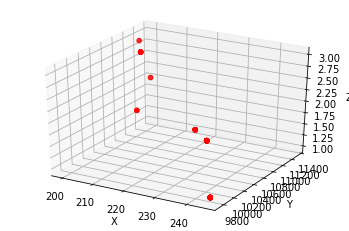

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

res_data = res.F.T
x = res_data[0]
y = res_data[1]
z = res_data[2]

# Créer la figure et l'axe 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Tracer le nuage de points
ax.scatter(x, y, z, c='r', marker='o')

# Définir les étiquettes des axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Afficher le graphique
plt.show()

<Figure size 432x288 with 0 Axes>

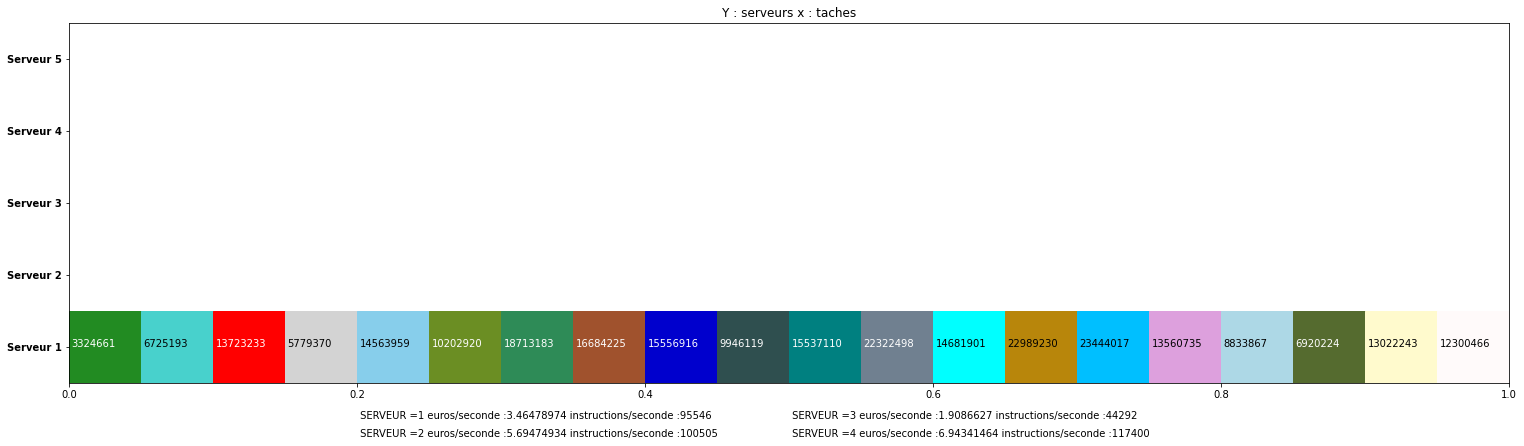

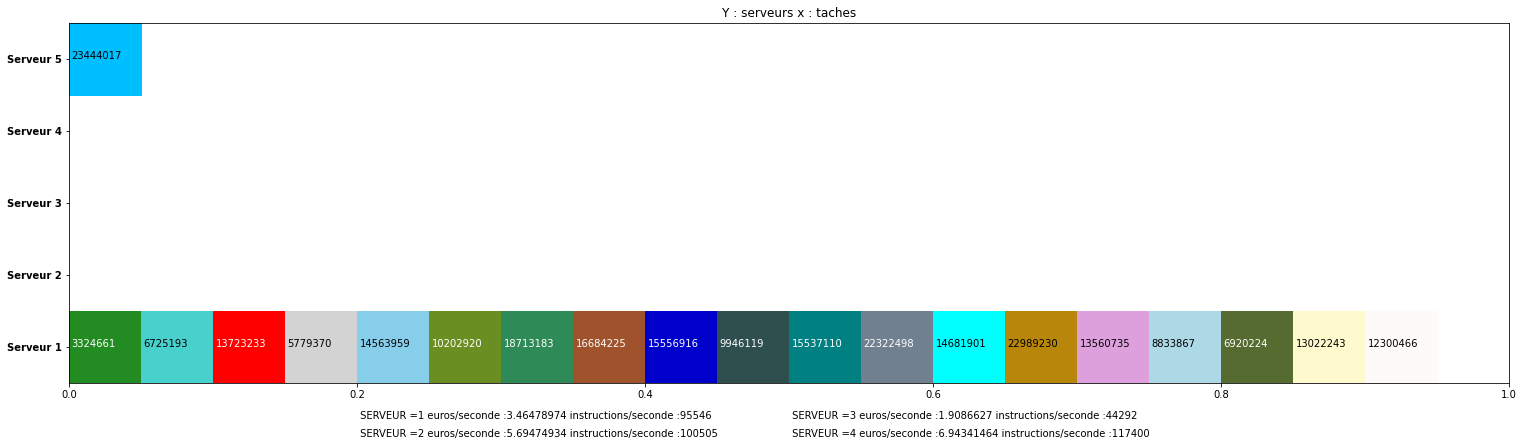

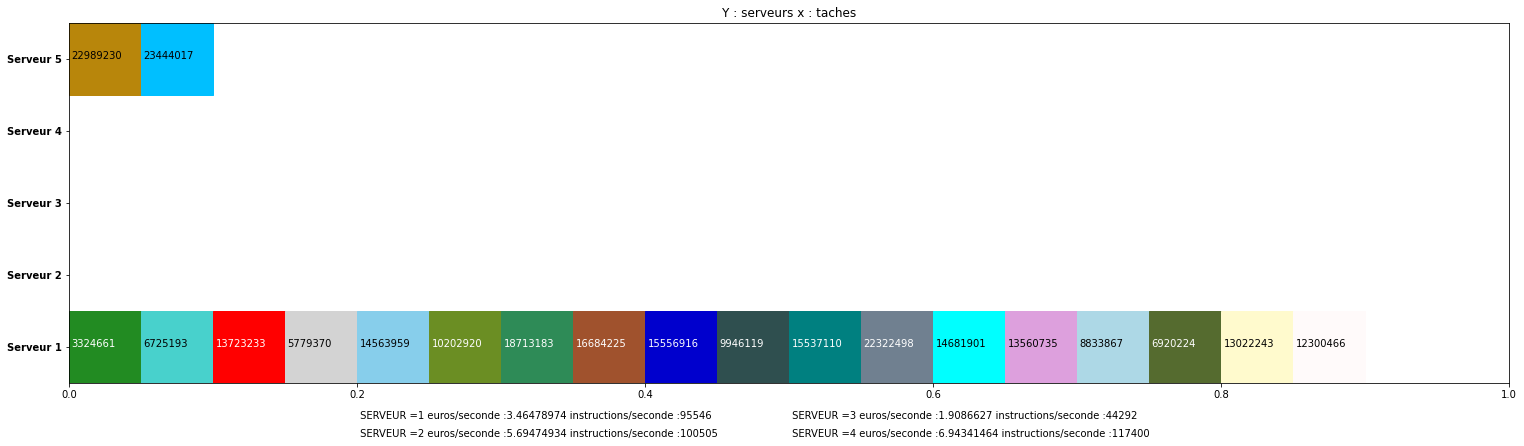

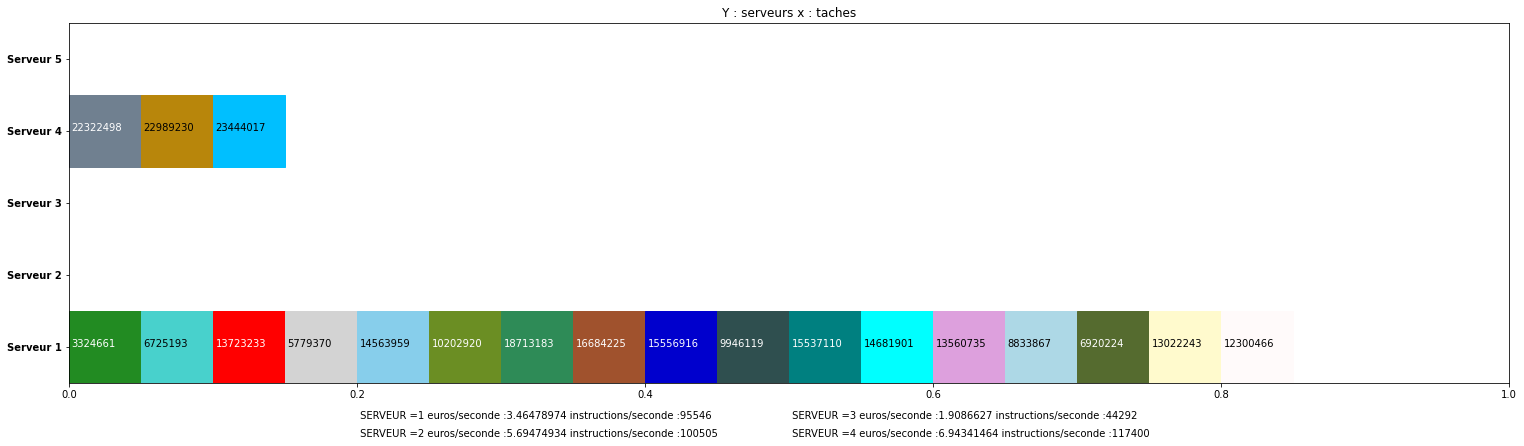

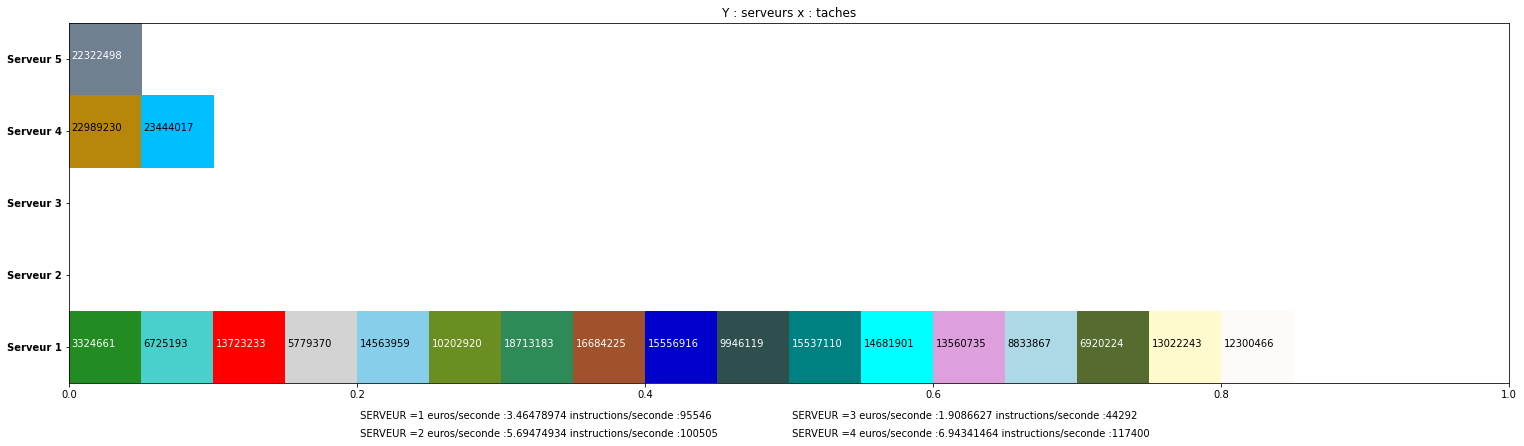

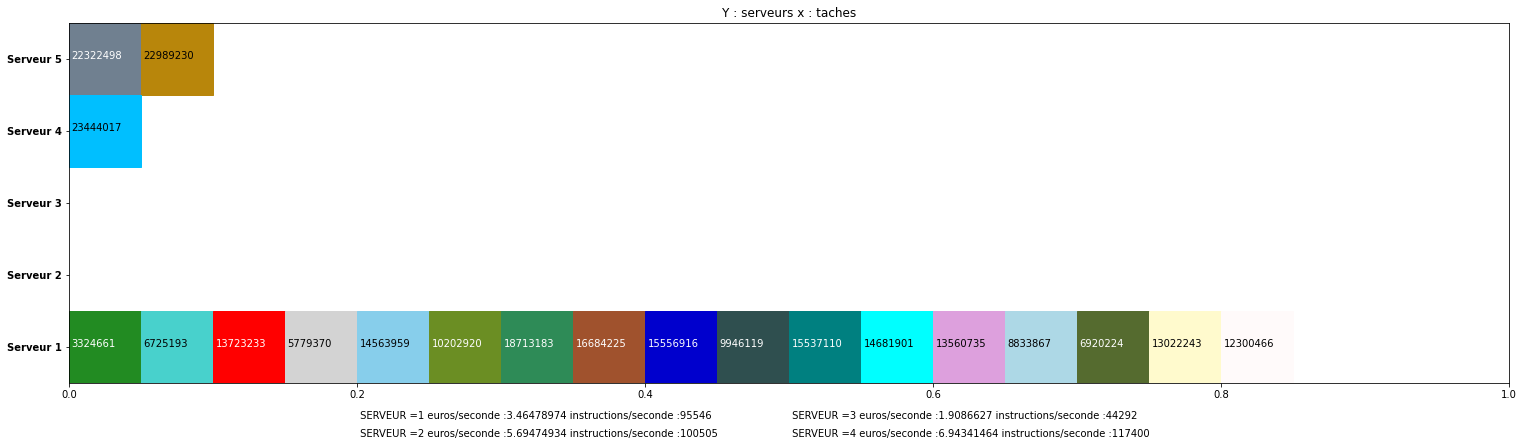

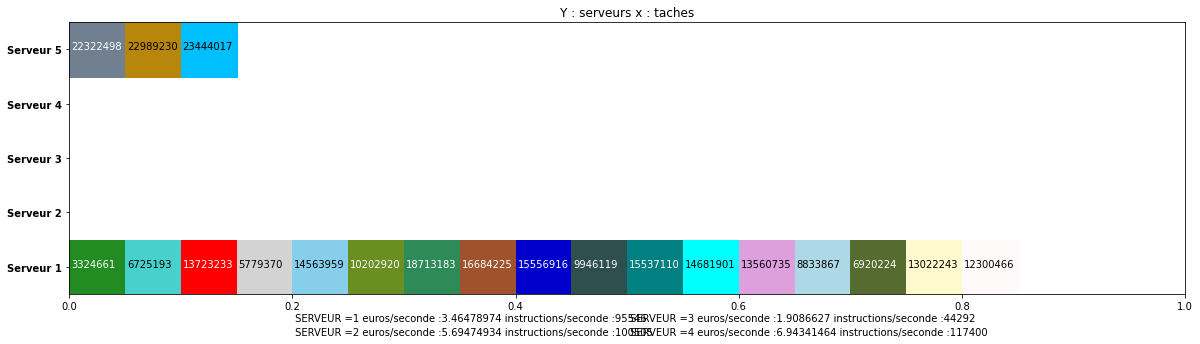

In [ ]:
from matplotlib import pyplot
import matplotlib
import colorsys
from matplotlib import colors

## create a colorfor each task
def add_color_to_list(float_list):
  color_map = {}
  color_list = []
  # Define a list of color names to choose from
  color_names = list(colors.CSS4_COLORS.keys())
  # Generate a unique color for each number in the input list
  for num in float_list:
      if num not in color_map:
          # Choose a random color name if we haven't seen this number before
          color_name = random.choice(color_names)
          color_map[num] = color_name
          color_names.remove(color_name)
      # Append the number and its associated color name to the color_list
      color_list.append((num, color_map[num]))
  return color_list

## Show result as graphs
def show_result(res_data,colorNames,t):
  for data in res_data:
    pyplot.gcf().subplots_adjust(0, 0, 1, 1)
    rowNbr = 5
    columnNbr = 20

    width = 1.0 / columnNbr
    height = 1.0 / rowNbr
    figure = pyplot.figure(figsize = (columnNbr, rowNbr))
    axes = figure.add_subplot(111)
    bars = ('Serveur 1', 'Serveur 2', 'Serveur 3', 'Serveur 4', 'Serveur 5')
    y_pos = [0.1,0.3,0.5,0.7,0.9]
    pyplot.yticks(y_pos, bars, color='black', rotation=0, fontweight='bold', fontsize='10', horizontalalignment='right')
    for d in range(0,4):
      plt.text(0.20+0.3*round(d/3), -0.1+(-0.05*round(d%2)), t[d], ha='left', rotation=0, wrap=True)
    pyplot.title('Solution '+'Y : serveurs x : taches') 
    x = np.zeros(5)
    i = 0
    y = 0
    for value in np.round(data).astype(int): 
      y =value*height 
      axes.add_artist(matplotlib.patches.Rectangle((x[value], y), width, height, color = colorNames[i][1]))
      (r, g, b) = matplotlib.colors.colorConverter.to_rgb(colorNames[i][1])
      Y = 0.2126 * r + 0.7152 * g + 0.0722 * b
      if Y > 0.5:
          textColor = 'black'
      else:
          textColor = 'white'
      axes.text(x[value] + width / 30, y + height / 2, colorNames[i][0], color = textColor)
      i = i+1
      x[value] = x[value] + width


## create text 
t=[]
for l in range(0,4):
  t.append(" SERVEUR ="+str(l+1)+" euros/seconde :"+str(cost[l])+" instructions/seconde :"+str(cpu[l]))    
## get data from NSGA 2
res_data_tmp = np.round(res.X).astype(int)
res_data = np.unique(res_data_tmp, axis=0)

## create colors for tasks
colorNames =  add_color_to_list(task)

## show result 
show_result(res_data,colorNames,t)
  
